In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

np.random.seed(42)
torch.manual_seed(42)

In [3]:
def create_features(df):
    features = pd.DataFrame(index=df.index)

    features['Close'] = df['Close']
    features['Open'] = df['Open']
    features['High'] = df['High']
    features['Low'] = df['Low']
    features['Volume'] = df['Volume']

    features['MA_7'] = df['Close'].rolling(7).mean()
    features['MA_21'] = df['Close'].rolling(21).mean()
    features['MA_50'] = df['Close'].rolling(50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['RSI'] = 100 - (100 / (1 + gain / loss))

    features['Volatility'] = df['Close'].rolling(14).std()
    features['Returns'] = df['Close'].pct_change()

    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    features['MACD'] = exp1 - exp2

    features['BB_middle'] = df['Close'].rolling(20).mean()
    features['BB_std'] = df['Close'].rolling(20).std()
    features['BB_upper'] = features['BB_middle'] + 2 * features['BB_std']
    features['BB_lower'] = features['BB_middle'] - 2 * features['BB_std']

    return features.dropna()


def prepare_basic(data, seq_len=60):
    prices = data[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(prices)

    X, y = [], []
    for i in range(len(scaled) - seq_len):
        X.append(scaled[i:i+seq_len])
        y.append(scaled[i+seq_len])

    return np.array(X), np.array(y), scaler


def prepare_enhanced(features_df, seq_len=60):
    feature_cols = [c for c in features_df.columns if c != 'Close']

    scaler_f = RobustScaler()
    scaler_t = MinMaxScaler(feature_range=(-1, 1))

    X_sc = scaler_f.fit_transform(features_df[feature_cols])
    y_sc = scaler_t.fit_transform(features_df[['Close']])

    all_data = np.hstack([X_sc, y_sc])

    X, y = [], []
    for i in range(len(all_data) - seq_len):
        X.append(all_data[i:i+seq_len])
        y.append(y_sc[i+seq_len])

    return np.array(X), np.array(y), scaler_t, scaler_f


class BasicLSTM(nn.Module):
    def __init__(self, inp=1, hid=32, layers=2):
        super().__init__()
        self.hid = hid
        self.layers = layers
        self.lstm = nn.LSTM(inp, hid, layers, batch_first=True)
        self.fc = nn.Linear(hid, 1)

    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hid)
        c0 = torch.zeros(self.layers, x.size(0), self.hid)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])


class EnhancedLSTM(nn.Module):
    def __init__(self, inp, hid=64, layers=3, drop=0.2):
        super().__init__()
        self.hid = hid
        self.layers = layers
        self.lstm = nn.LSTM(inp, hid, layers, batch_first=True, dropout=drop if layers > 1 else 0)
        self.fc1 = nn.Linear(hid, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hid)
        c0 = torch.zeros(self.layers, x.size(0), self.hid)
        out, _ = self.lstm(x, (h0, c0))
        out = self.drop(out[:, -1, :])
        out = self.relu(self.fc1(out))
        return self.fc2(out)


def train(model, X, y, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    X_t = torch.FloatTensor(X)
    y_t = torch.FloatTensor(y)

    losses = []
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        out = model(X_t)
        loss = criterion(out, y_t)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        sched.step(loss)
        losses.append(loss.item())
        if ep % 10 == 0:
            print(f"Epoch {ep:3d}, Loss: {loss.item():.6f}")

    return losses


def forecast_multi(model, seq, scaler, days=30, mode='basic'):
    model.eval()
    preds = []
    confs = []
    cur = torch.FloatTensor(seq).unsqueeze(0)

    with torch.no_grad():
        for d in range(days):
            p = model(cur)
            preds.append(p.item())
            confs.append(max(0, 1 - d * 0.03))

            if mode == 'basic':
                new_inp = p.view(1, 1, 1)
                cur = torch.cat([cur[:, 1:, :], new_inp], dim=1)
            else:
                new_row = cur[:, -1:, :].clone()
                new_row[:, :, -1] = p
                cur = torch.cat([cur[:, 1:, :], new_row], dim=1)

    return preds, confs


def evaluate(model, X, y, scaler):
    model.eval()
    X_t = torch.FloatTensor(X)

    with torch.no_grad():
        preds = model(X_t).numpy()

    pred_inv = scaler.inverse_transform(preds)
    y_inv = scaler.inverse_transform(y)

    return {
        'rmse': np.sqrt(mean_squared_error(y_inv, pred_inv)),
        'mae': mean_absolute_error(y_inv, pred_inv),
        'mape': mean_absolute_percentage_error(y_inv, pred_inv) * 100,
        'preds': pred_inv,
        'actual': y_inv
    }

In [4]:
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))

print(f"Загружено {len(data)} записей")
print(f"Период: {data.index[0].date()} - {data.index[-1].date()}")
print(data['Close'].describe())

data['Returns'] = data['Close'].pct_change()
data['Vol_30d'] = data['Returns'].rolling(30).std() * np.sqrt(365) * 100
print(f"\nСредняя волатильность: {data['Vol_30d'].mean():.2f}%")

[*********************100%***********************]  1 of 1 completed

Загружено 2172 записей
Период: 2020-01-01 - 2025-12-11
Ticker        BTC-USD
count     2172.000000
mean     46820.750598
std      31320.054944
min       4970.788086
25%      21783.466309
50%      39453.376953
75%      63912.121094
max     124752.531250

Средняя волатильность: 56.57%


In [5]:
np.random.seed(42)
true_vals = np.cumsum(np.random.randn(100)) + 100

err = 0.01
p1, pm = [], []

for i in range(len(true_vals)):
    p1.append(true_vals[max(0, i-1)] * (1 + np.random.uniform(-err, err)))
    if i == 0:
        pm.append(true_vals[0] * (1 + np.random.uniform(-err, err)))
    else:
        pm.append(pm[-1] * (1 + np.random.uniform(-err, err)))

print("Демонстрация накопления ошибок:")
print(f"Одношаговый на 100 шаге: {abs(true_vals[-1] - p1[-1]):.2f}")
print(f"Многошаговый на 100 шаге: {abs(true_vals[-1] - pm[-1]):.2f}")

Демонстрация накопления ошибок:
Одношаговый на 100 шаге: 0.09
Многошаговый на 100 шаге: 7.09


In [6]:
prices = data['Close'].values.reshape(-1, 1)

scalers = {
    'MinMax (0,1)': MinMaxScaler((0, 1)),
    'MinMax (-1,1)': MinMaxScaler((-1, 1)),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

print("Сравнение нормализации:\n")
for name, sc in scalers.items():
    scaled = sc.fit_transform(prices)
    print(f"{name}: min={scaled.min():.3f}, max={scaled.max():.3f}, last={scaled[-1][0]:.3f}")

Сравнение нормализации:

MinMax (0,1): min=0.000, max=1.000, last=0.731
MinMax (-1,1): min=-1.000, max=1.000, last=0.462
Standard: min=-1.337, max=2.489, last=1.459
Robust: min=-0.819, max=2.025, last=1.259


In [7]:
features_df = create_features(data)
print(f"Признаков: {len(features_df.columns)}")
print(list(features_df.columns))

Признаков: 16
['Close', 'Open', 'High', 'Low', 'Volume', 'MA_7', 'MA_21', 'MA_50', 'RSI', 'Volatility', 'Returns', 'MACD', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower']


In [8]:
seq_len = 60

X_b, y_b, sc_b = prepare_basic(data, seq_len)
split = int(0.8 * len(X_b))
X_tr_b, X_te_b = X_b[:split], X_b[split:]
y_tr_b, y_te_b = y_b[:split], y_b[split:]

print("Базовая модель:")
model_b = BasicLSTM(1, 32, 2)
loss_b = train(model_b, X_tr_b, y_tr_b, epochs=50)

Базовая модель:
Epoch   0, Loss: 0.069264
Epoch  10, Loss: 0.025586
Epoch  20, Loss: 0.023654
Epoch  30, Loss: 0.021469
Epoch  40, Loss: 0.020621


In [9]:
X_e, y_e, sc_t, sc_f = prepare_enhanced(features_df, seq_len)
split_e = int(0.8 * len(X_e))
X_tr_e, X_te_e = X_e[:split_e], X_e[split_e:]
y_tr_e, y_te_e = y_e[:split_e], y_e[split_e:]

print("Улучшенная модель:")
model_e = EnhancedLSTM(X_e.shape[2], 64, 3)
loss_e = train(model_e, X_tr_e, y_tr_e, epochs=50)

Улучшенная модель:
Epoch   0, Loss: 0.285831
Epoch  10, Loss: 0.115946
Epoch  20, Loss: 0.023147
Epoch  30, Loss: 0.014191
Epoch  40, Loss: 0.010699


In [10]:
fc_b, conf_b = forecast_multi(model_b, X_te_b[-1], sc_b, 30, 'basic')
fc_b_inv = sc_b.inverse_transform(np.array(fc_b).reshape(-1, 1))

fc_e, conf_e = forecast_multi(model_e, X_te_e[-1], sc_t, 30, 'enhanced')
fc_e_inv = sc_t.inverse_transform(np.array(fc_e).reshape(-1, 1))

print("30-дневный прогноз:\n")
print(f"Базовая: ${fc_b_inv[0][0]:,.0f} -> ${fc_b_inv[-1][0]:,.0f} ({(fc_b_inv[-1][0]/fc_b_inv[0][0]-1)*100:.1f}%)")
print(f"Улучшенная: ${fc_e_inv[0][0]:,.0f} -> ${fc_e_inv[-1][0]:,.0f} ({(fc_e_inv[-1][0]/fc_e_inv[0][0]-1)*100:.1f}%)")

30-дневный прогноз:

Базовая: $38,365 -> $35,214 (-8.2%)
Улучшенная: $63,728 -> $63,817 (0.1%)


In [11]:
m_b = evaluate(model_b, X_te_b, y_te_b, sc_b)
m_e = evaluate(model_e, X_te_e, y_te_e, sc_t)

print("Метрики:\n")
print(f"Базовая:     RMSE=${m_b['rmse']:,.0f}  MAE=${m_b['mae']:,.0f}  MAPE={m_b['mape']:.1f}%")
print(f"Улучшенная:  RMSE=${m_e['rmse']:,.0f}  MAE=${m_e['mae']:,.0f}  MAPE={m_e['mape']:.1f}%")

Метрики:

Базовая:     RMSE=$62,094  MAE=$60,818  MAPE=60.4%
Улучшенная:  RMSE=$38,338  MAE=$36,449  MAPE=35.3%


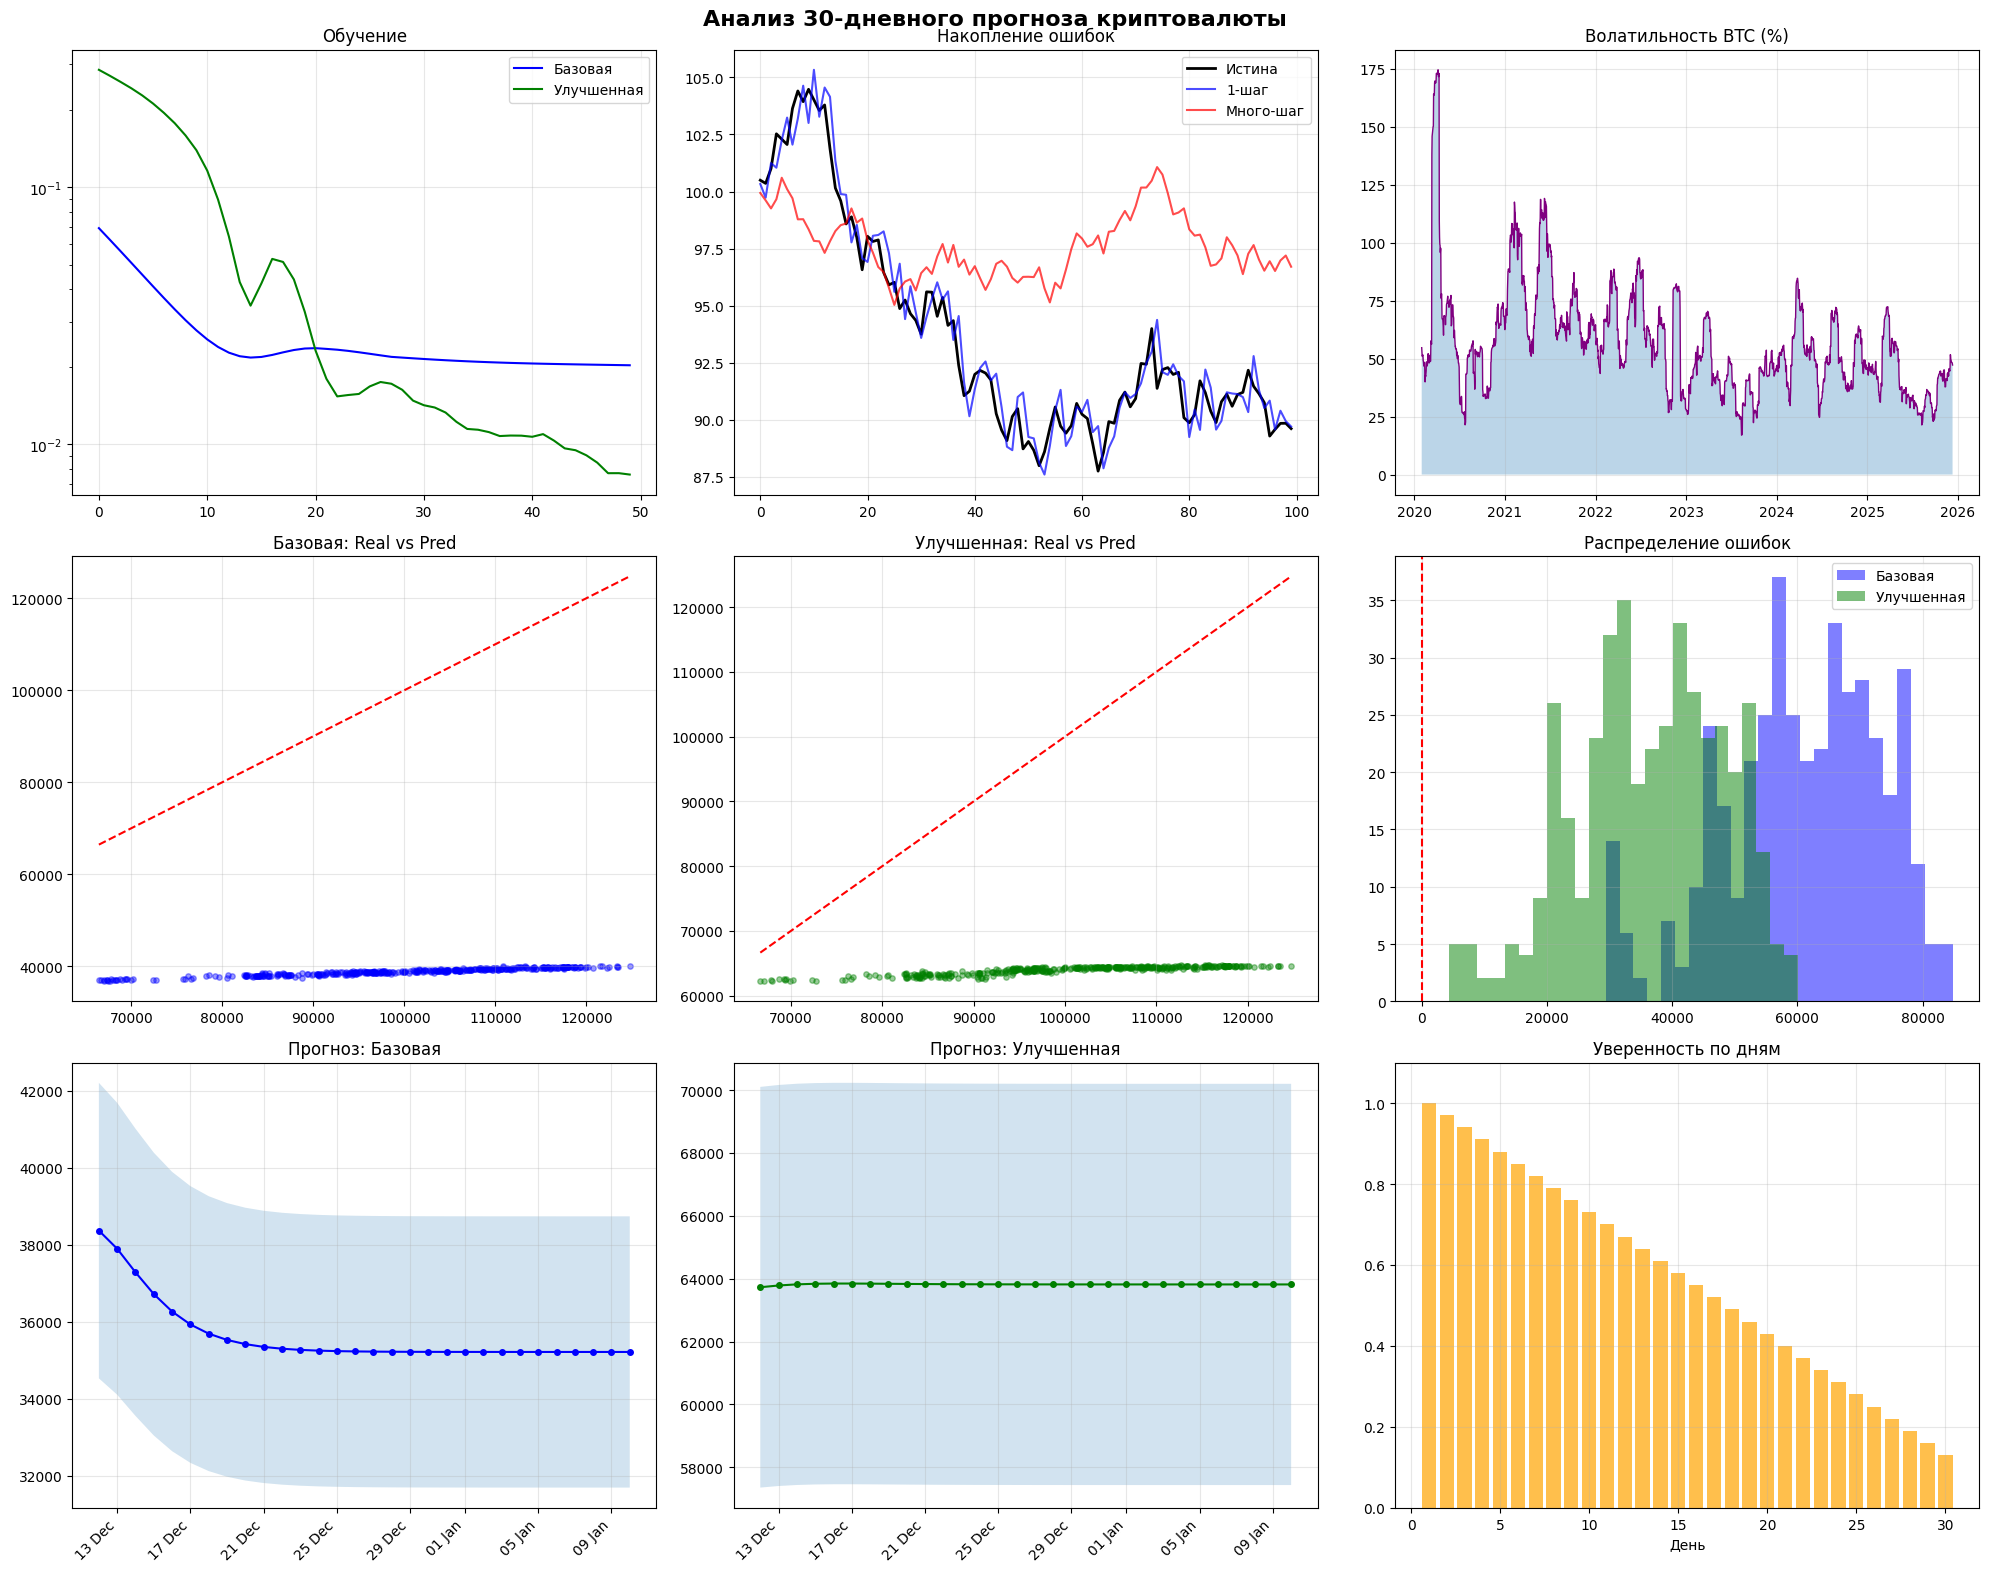

In [12]:
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Анализ 30-дневного прогноза криптовалюты", fontsize=16, fontweight='bold')

ax1 = fig.add_subplot(3, 3, 1)
ax1.plot(loss_b, 'b-', label='Базовая')
ax1.plot(loss_e, 'g-', label='Улучшенная')
ax1.set_title('Обучение')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(3, 3, 2)
ax2.plot(true_vals, 'k-', lw=2, label='Истина')
ax2.plot(p1, 'b-', alpha=0.7, label='1-шаг')
ax2.plot(pm, 'r-', alpha=0.7, label='Много-шаг')
ax2.set_title('Накопление ошибок')
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(3, 3, 3)
ax3.plot(data['Vol_30d'], 'purple', lw=1)
ax3.fill_between(data.index, 0, data['Vol_30d'], alpha=0.3)
ax3.set_title('Волатильность BTC (%)')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(3, 3, 4)
ax4.scatter(m_b['actual'], m_b['preds'], alpha=0.4, c='blue', s=15)
mn, mx = m_b['actual'].min(), m_b['actual'].max()
ax4.plot([mn, mx], [mn, mx], 'r--')
ax4.set_title('Базовая: Real vs Pred')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(3, 3, 5)
ax5.scatter(m_e['actual'], m_e['preds'], alpha=0.4, c='green', s=15)
mn, mx = m_e['actual'].min(), m_e['actual'].max()
ax5.plot([mn, mx], [mn, mx], 'r--')
ax5.set_title('Улучшенная: Real vs Pred')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(3, 3, 6)
ax6.hist(m_b['actual'] - m_b['preds'], bins=25, alpha=0.5, color='blue', label='Базовая')
ax6.hist(m_e['actual'] - m_e['preds'], bins=25, alpha=0.5, color='green', label='Улучшенная')
ax6.axvline(0, color='red', ls='--')
ax6.set_title('Распределение ошибок')
ax6.legend()
ax6.grid(alpha=0.3)

ax7 = fig.add_subplot(3, 3, 7)
dates = pd.date_range(data.index[-1], periods=31)[1:]
ax7.plot(dates, fc_b_inv, 'bo-', ms=4, label='Базовая')
ax7.fill_between(dates, fc_b_inv.flatten()*0.9, fc_b_inv.flatten()*1.1, alpha=0.2)
ax7.set_title('Прогноз: Базовая')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.setp(ax7.get_xticklabels(), rotation=45, ha='right')
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(3, 3, 8)
ax8.plot(dates, fc_e_inv, 'go-', ms=4, label='Улучшенная')
ax8.fill_between(dates, fc_e_inv.flatten()*0.9, fc_e_inv.flatten()*1.1, alpha=0.2)
ax8.set_title('Прогноз: Улучшенная')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.setp(ax8.get_xticklabels(), rotation=45, ha='right')
ax8.grid(alpha=0.3)

ax9 = fig.add_subplot(3, 3, 9)
ax9.bar(range(1, 31), conf_b, color='orange', alpha=0.7)
ax9.set_title('Уверенность по дням')
ax9.set_xlabel('День')
ax9.set_ylim(0, 1.1)
ax9.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Причины плохого 30-дневного прогноза:

1. Накопление ошибок.
   Каждое предсказание становится входом для следующего.
   Ошибка 1% за 30 дней превращается в 30-50%.

2. Мало признаков.
   Только Close не учитывает объём, волатильность,
   технические индикаторы и внешние факторы.

3. Нормализация на границе.
   MinMax(0,1) даёт значения близкие к 1 на максимумах.
   Модель упирается в потолок и предсказывает падение.

4. Волатильность 50-100%;
   Криптовалюты слишком непредсказуемы для
   долгосрочного прогноза по историческим данным.